In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os
#import scipy.io.wavfile as wav
from tempfile import TemporaryFile

from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank

import aubio

from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
def plotWave (y, pltLen):
    x = np.arange(pltLen)
    plt.plot(x,y[0:pltLen])
    plt.show()

In [3]:
def getBlocks (filename, win_s, sampleRate = 44100):
    hop_s = win_s // 2                                 # hop size
    fft_s = win_s // 2
    
    f = aubio.source(filename, sampleRate, win_s)
    samplerate = f.samplerate
    
    signal = np.zeros([win_s, 0])
    
    total_frames, read = 0, f.hop_size
    while read:
        vec, read = f()
        total_frames += read
        signal = np.hstack( (signal, vec.reshape((len(vec), 1)) ) )
        
        #plotWave(fft, len(fft))
        
        if read < f.hop_size: break
    
    
    
    #curtail if energy too low
    energy = np.sum(np.abs(signal), axis = 0)
    max_energy = np.max(energy)
    thresh = 0.05
    for i in range(signal.shape[1]):
        if (energy[i] < thresh*max_energy and i > 2):
            #added the i>2 condition to avoid errors w/ delayed signals
            signal = signal[:, 0:i]
            break
    
    
    #compute 50% overlap 
    signal_over = np.zeros([win_s , 0])
    for i in range(signal.shape[1]):
        signal_over = np.hstack( (signal_over, signal[:,i].reshape(win_s, 1) ) )
        if (i==signal.shape[1]-1):
            break
        over = np.hstack((signal[win_s/2:win_s, i], signal[0:win_s/2, i+1]))
        signal_over = np.hstack( (signal_over, over.reshape(len(over), 1) ) )
        
    print(signal_over.shape)
    
    outstr = "read %.2fs" % (total_frames / float(samplerate))
    outstr += " (%d frames in" % total_frames
    outstr += " %d blocks" % (total_frames // f.hop_size)
    outstr += " at %dHz)" % f.samplerate
    outstr += " from " + f.uri
    print(outstr)
    
    return [signal_over, samplerate]

In [4]:
def curtail(data, start, length):
    sizeAfterStart = len(data) - start
    if (sizeAfterStart < length):
        # pads zeros for short clips to avoid fft errors
        z = np.zeros(length - sizeAfterStart)
        #z = data[start: start + (length - sizeAfterStart)]
        data  = np.append(data, z)
    return data[start:start+length]

In [5]:
def minMaxNorm(data):
    MAX = np.amax(data)
    MIN = np.amin(data)
    return (data-MIN)/(MAX-MIN)

In [6]:
def getFFT (data, applyWin):
    #print(fftSize)
    blockSize = data.shape[0]
    
    if (applyWin):
        win = np.hamming(blockSize).reshape((blockSize, 1))
    else:
        win = np.ones((blockSize, 1))
        
    mult = np.multiply(data,win)
    fft = np.fft.rfft(mult, axis = 0, norm = "ortho") 
    magnitude = np.abs(fft)
    m = np.mean(magnitude)
    fftSpectrum = np.log10( magnitude + m*0.0001)
    # add minmaxnorm ??????
    
    returnSpectrum = minMaxNorm(fftSpectrum)
    
    #print(fft.shape)
    return returnSpectrum

In [7]:
def melFeature (data, rate, fftSize):
    
    ### Mel Features ###
    mfcc_feat = mfcc(data, rate, nfft = fftSize)
    #print(mfcc_feat.shape)
    deltas = delta(mfcc_feat, 2)
    #print(d_mfcc_feat.shape)
    melFeatures = logfbank(data, rate, winstep=0.0125, nfft = fftSize)
    
    #normalize
    melFeatures = minMaxNorm(melFeatures)
    #print(melEnergies.shape)
    
    return melFeatures

In [8]:
win_s = 1024

In [25]:
sampleCount = 0
featureList = np.empty((1,4),dtype='object')
allowed_rate = 44100

fileSearch = "808 Bass Key .wav"
exclude = set(["test set", "Vocals & Chants", "Silence", "Analog Drums", "Drum Loops", "pyAudioAnalysis"])

for root, dirs, files in os.walk(".", topdown=True):
    dirs[:] = [d for d in dirs if d not in exclude]
    
    wav_files = [ fi for fi in files if fi.endswith(fileSearch) or (fi.endswith(".wav") or fi.endswith(".WAV")) ]
    for name in wav_files:
        fullpath = os.path.join(root, name)
        print(name)
        
        
        wav_file = getBlocks (fullpath, win_s, allowed_rate)
        audio = wav_file[0]
        rate = wav_file[1]
    
        fft_time_series = getFFT(audio, True)
        mel_time_series = melFeature(audio.reshape((np.prod(audio.shape), 1)), allowed_rate, win_s/2)
        print("bitch")
        print(mel_time_series.shape)
        print("EFUhdso")
        # make frames to make shape (nfilt, NumFrames)
        mel_time_series = np.transpose(mel_time_series)
        
        
        vector = np.array([[name], [root], [fft_time_series], [mel_time_series]], dtype='object')
        featureList = np.vstack((featureList, np.transpose(vector)))
    
        
        sampleCount += 1
        
    for name in dirs:
        sampleCount += 0 
        #print(os.path.join(root, name))

#Truncate first row of 'None'
featureList = featureList[1:, :]

print("Sample Count")
print(sampleCount)
print("Feature List shape")
print(featureList.shape)

print('-------------Done Generating Features ----------------')

01 HHclosed02.wav
(1024, 5)
read 0.08s (3576 frames in 3 blocks at 44100Hz) from ./Cymbals/01 HHclosed02.wav
bitch
(9, 26)
EFUhdso
01 HHclosed08.wav
(1024, 7)
read 0.10s (4207 frames in 4 blocks at 44100Hz) from ./Cymbals/01 HHclosed08.wav
bitch
(13, 26)
EFUhdso
42-SabianRockHatClosed-1.wav
(1024, 7)
read 0.25s (11046 frames in 10 blocks at 44100Hz) from ./Cymbals/42-SabianRockHatClosed-1.wav
bitch
(13, 26)
EFUhdso
42-SabianRockHatClosed-2.wav
(1024, 7)
read 0.35s (15463 frames in 15 blocks at 44100Hz) from ./Cymbals/42-SabianRockHatClosed-2.wav
bitch
(13, 26)
EFUhdso
42-SabianRockHatClosed-3.wav
(1024, 13)
read 0.35s (15455 frames in 15 blocks at 44100Hz) from ./Cymbals/42-SabianRockHatClosed-3.wav
bitch
(24, 26)
EFUhdso
42-SabianRockHatClosed-4.wav
(1024, 9)
read 0.35s (15404 frames in 15 blocks at 44100Hz) from ./Cymbals/42-SabianRockHatClosed-4.wav
bitch
(16, 26)
EFUhdso
42-SabianRockHatClosed-5.wav
(1024, 11)
read 0.35s (15443 frames in 15 blocks at 44100Hz) from ./Cymbals/42-Sabi

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: AUBIO WARNING: source_apple_audio: up-sampling ./Subbass/BD_2.wav from 8000Hz to 44100Hz


(1024, 65)
read 0.81s (35831 frames in 34 blocks at 44100Hz) from ./Subbass/BD_2.wav
bitch
(120, 26)
EFUhdso
BEASTBASS  808 2.wav
(1024, 175)
read 3.79s (167148 frames in 163 blocks at 44100Hz) from ./Subbass/BEASTBASS  808 2.wav
bitch
(325, 26)
EFUhdso
BEASTBASS  808.wav
(1024, 169)
read 2.62s (115762 frames in 113 blocks at 44100Hz) from ./Subbass/BEASTBASS  808.wav
bitch
(314, 26)
EFUhdso
BOOMIN 808 1.wav
(1024, 171)
read 3.20s (141304 frames in 137 blocks at 44100Hz) from ./Subbass/BOOMIN 808 1.wav
bitch
(317, 26)
EFUhdso
BOOMIN 808 2 MUDDY.wav
(1024, 163)
read 2.12s (93572 frames in 91 blocks at 44100Hz) from ./Subbass/BOOMIN 808 2 MUDDY.wav
bitch
(302, 26)
EFUhdso
BOOMIN 808 3 SHORT.wav
(1024, 153)
read 3.00s (132301 frames in 129 blocks at 44100Hz) from ./Subbass/BOOMIN 808 3 SHORT.wav
bitch
(284, 26)
EFUhdso
BOOMIN BASS 1.wav
(1024, 129)
read 1.71s (75284 frames in 73 blocks at 44100Hz) from ./Subbass/BOOMIN BASS 1.wav
bitch
(239, 26)
EFUhdso
BOOMIN OG 808.wav
(1024, 251)
read 

Clap 017 Clap Snare.wav
(26, 20)


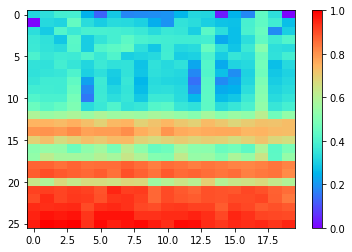

In [31]:
index = 600
sample = featureList[index,:]
s = sample[3]
print(sample[0])
print(s.shape)
plt.imshow(s[:,:], cmap='rainbow', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

Clap 017 Clap Snare.wav
(513, 11)


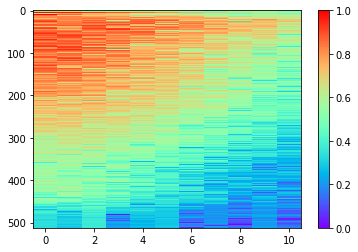

In [32]:
sample = featureList[index,:]
s = sample[2]
print(sample[0])
print(s.shape)
plt.imshow(s[:,:], cmap='rainbow', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
fft_list = [i.transpose().tolist() for i in featureList[:,2].tolist() ]
mel_list = [i.transpose().tolist() for i in featureList[:,3].tolist() ]


fft_list_padded = sequence.pad_sequences(fft_list, dtype='float32', padding='post', value=0.)
mel_list_padded = sequence.pad_sequences(mel_list, dtype='float32', padding='post', value=0.)

rnnInput = np.empty((1,4),dtype='object')
featureList[0,:] = [featureList[:,0], featureList[:,1], fft_list_padded, mel_list_padded]
print(featureList[:,2].shape)
print(featureList[:,3].shape)

np.savez_compressed('data/time_series_normalized.npy', featureList) # save compressed

"""
features_Mel[:,2].reshape(())

sequences = features_Mel.reshape(())
features = sequence.pad_sequences(sequences, dtype='float32', padding='post', value=0.)
print(features.shape)
"""

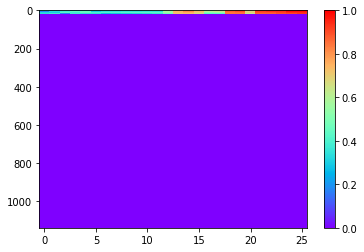

In [30]:
plt.imshow(mel_list_padded[index,:,:], cmap='rainbow', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

855
WALLA MAJIC 808.wav
./Subbass


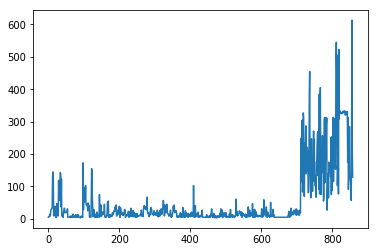

In [13]:
maxLength = np.argmax(lengths[:])
print(maxLength)
print(features_FFT[maxLength, 0])
print(features_FFT[maxLength, 1])
plotWave(lengths, len(lengths[:]))

#print(s[:,:])
#print(sequence.pad_sequences(l, dtype='float32', value=0.))

In [111]:
arrays = [np.random.randn(3, 4) for _ in range(10)]
print(arrays[0].shape)
p = np.stack(arrays, axis=0)
arrays = [np.random.randn(3, 4) for _ in range(10)]
np.stack((p,arrays), axis=0).shape

(3, 4)


(2, 10, 3, 4)